In [ ]:
import requests
from bs4 import BeautifulSoup
import mysql.connector
import time

conn = mysql.connector.connect(
    host="localhost",  
    user="root", 
    database="IPHONE",
    password="12345"
)
cursor = conn.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS Reviews
                  (review_title TEXT, review_text TEXT, style_name TEXT, color TEXT, verified_purchase TEXT)''')

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

session = requests.Session()
session.headers.update(headers)

reviews = []

def get_reviews(url):
    while url:
        response = session.get(url)

        if response.status_code != 200:
            print(f"Failed to retrieve page: {response.status_code}")
            break

        soup = BeautifulSoup(response.content, 'html.parser')



        for review in soup.find_all('div', class_="a-section review aok-relative"):

            format_strip = review.find('span', {'data-hook': 'format-strip-linkless'}).text.strip()

            title_ = review.find('a', class_="a-size-base a-link-normal review-title a-color-base review-title-content a-text-bold").text.strip()
            title = title_.split('\n', 1)[1]
            text = review.find('span', class_='review-text').text.strip()
            storage_size = format_strip.split('Size:')[-1].split('Pattern Name:')[0].strip()
            color = format_strip.split('Colour:')[-1].split('Size:')[0].strip()
            verified_purchase = "Verified Purchase" in review.text
            verified_purchase = 'Yes' if verified_purchase else 'No'
            
            reviews.append({
                'Review Title': title,
                'Review Text': text,
                'Storage Size': storage_size,
                'Color': color,
                'Verified Purchase': verified_purchase 
            })

            cursor.execute('''INSERT INTO Reviews (review_title, review_text, style_name, color, verified_purchase)
                                      VALUES (%s, %s, %s, %s, %s)''', (title, text, storage_size, color, verified_purchase))

            print(f"@Title: {title}, Text: {text}, Style: {storage_size}, Color: {color}, Verified: {verified_purchase}")

            
            all_rev = soup.find('a', {'data-hook': 'see-all-reviews-link-foot', 'class': 'a-link-emphasis a-text-bold'})
            if all_rev:
                all_rev_url = "https://www.amazon.in" + all_rev['href']
                print(f"All reviews URL: {all_rev_url}")
                url = all_rev_url
            else:
                print("No 'See All Reviews' link found.")
                url = None

            next_button = soup.find('li', class_='a-last')
            if next_button and next_button.a:
                url = "https://www.amazon.in" + next_button.a['href']
                print(url)
            else:
                url = None
                print('NOne')
            time.sleep(2)
            
base_url = "https://www.amazon.in/Apple-New-iPhone-12-128GB/dp/B08L5TNJHG"

get_reviews(base_url)
get_reviews('https://www.amazon.in/New-Apple-iPhone-12-128GB/product-reviews/B08L5TNJHG')

conn.commit()
cursor.close()
conn.close()


print(reviews)

In [13]:
import mysql.connector
from collections import Counter
import re
import nltk


from nltk.corpus import stopwords


conn = mysql.connector.connect(
    host="localhost", 
    user="root", 
    database="IPHONE", 
    password="12345"
)

cursor = conn.cursor()


cursor.execute('SELECT review_text FROM Reviews')
reviews = cursor.fetchall()


cursor.close()
conn.close()

all_reviews_text = ' '.join([review[0] for review in reviews])

def extract_keywords(text):
    words = re.findall(r'\b\w+\b', text.lower())
    
    stop_words = set(stopwords.words('english'))
    
    custom_stop_words = {'iphone', 'apple', 'product', 'amazon', 'review'}
    stop_words.update(custom_stop_words)
    
    keywords = [word for word in words if word not in stop_words and len(word) > 2]
    
    return keywords

keywords = extract_keywords(all_reviews_text)

keyword_counter = Counter(keywords)

best_keywords = keyword_counter.most_common(10)
print("Best Keywords (Most Frequent):\n\n", best_keywords)
print()
worst_keywords = keyword_counter.most_common()[-10:]
print("Worst Keywords (Least Frequent):\n\n", worst_keywords)



Best Keywords (Most Frequent):

 [('phone', 53), ('android', 46), ('battery', 34), ('really', 34), ('device', 29), ('camera', 28), ('ios', 28), ('like', 24), ('user', 23), ('charging', 22)]

Worst Keywords (Least Frequent):

 [('dies', 1), ('main', 1), ('stand', 1), ('overheats', 1), ('unsure', 1), ('whatever', 1), ('despise', 1), ('moves', 1), ('replaced', 1), ('okay', 1)]


In [3]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import pandas as pd
import mysql.connector

conn = mysql.connector.connect(
    host="localhost",  
    user="root",       
    password="12345",  
    database="IPHONE"  
)

cursor = conn.cursor()

query = 'SELECT * FROM reviews'
cursor.execute(query)

rows = cursor.fetchall()

column_names = [i[0] for i in cursor.description]

cursor.close()
conn.close()

df = pd.DataFrame(rows, columns= column_names)

csv = 'reviews_data.csv'
df.to_csv(csv, index=False)



In [19]:
data = pd.read_csv("reviews_data.csv")
data.head()

,id,review_title,review_text,style_name,color,verified_purchase
0,1,I like Amazon product,"I like Amazon product, Helpful Report",128GB,NaN,Yes
1,2,Photo,"Nice camera, Customer image, One person found ...",128GB,Black,Yes
2,3,Beast,"Hello there, I am writing this review after 3-...",128GB,Black,Yes
3,4,Phone is great but iOS sucks,"First of all, I don't know why people here are...",128GB,NaN,Yes
4,5,Camara quality is very nice,Mobile is speed Customer image Helpful Report,128GB,NaN,Yes


<AxesSubplot:xlabel='style_name', ylabel='count'>

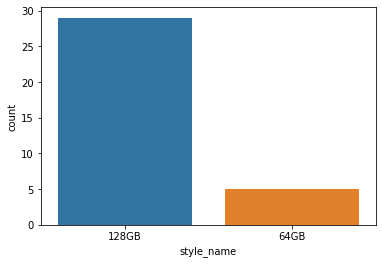

In [16]:
sns.countplot(data.style_name)

In [20]:
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["review_text"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["review_text"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["review_text"]]
data = data[["review_text", "Positive", "Negative", "Neutral"]]
data.head()

,review_text,Positive,Negative,Neutral
0,"I like Amazon product, Helpful Report",0.778,0.000,0.222
1,"Nice camera, Customer image, One person found ...",0.525,0.000,0.475
2,"Hello there, I am writing this review after 3-...",0.143,0.050,0.807
3,"First of all, I don't know why people here are...",0.088,0.065,0.847
4,Mobile is speed Customer image Helpful Report,0.318,0.000,0.682


In [21]:
x = sum(data["Positive"])
y = sum(data["Negative"])
z = sum(data["Neutral"])

In [22]:
def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 


In [23]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  8.618
Negative:  1.305
Neutral:  24.077000000000005


Most of the reviews are in favor of Neutral.
The Negative review score has a small proportion, and Positive reviews are midway.
So with the help of the above sentiment analysis implementation, we can conclude that most people are satisfied with the IPHONE 12 and its features they received from Amazon.